In [ ]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML, Javascript
display(HTML('''<style>.jp-Cell.jp-CodeCell .jp-OutputArea:has(.jp-OutputArea-output) {background-color: #f9f9f9;border: 1px solid #ddd;padding: 10px;border-radius: 5px;margin: 5px 0;}</style><style>.prompt, .jp-InputPrompt {display:none !important;}</style>'''))

# Preparing input data for a ROMS simulation

If we want to build a `C-Star` blueprint from scratch, we first have to make the input data for our new ROMS simulation. The path to the input data files will then go into the C-Star blueprint.

In this notebook, we prepare all the input data necessary for a ROMS simulation. This includes the 

* grid
* initial conditions
* tidal forcing
* surface forcing
* boundary forcing

Let's prepare these input data for the following simulation period: a week in mid-August 2012.

In [1]:
from datetime import datetime
start_time = datetime(2012, 8, 10)
end_time = datetime(2012, 8, 17)

We will save the input datasets in a designated target directory in our scratch directory.

In [2]:
import os
target_dir = os.path.join(os.getenv('PSCRATCH'), 'ROMS_TOOLS_INPUT_DATA')
target_dir

'/pscratch/sd/n/nloose/ROMS_TOOLS_INPUT_DATA'

In [3]:
# Create the directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

The generation of the ROMS input files is handled by a python package called [ROMS-Tools](https://roms-tools.readthedocs.io/en/latest/index.html), which is a dependency of `C-Star`.

In [4]:
import roms_tools

## Grid

In [5]:
from roms_tools import Grid

Let's make a new domain in the North Atlantic, one that surrounds Iceland.

In [6]:
%%time

grid = Grid(
    nx=30,  # number of points in the x-direction (not including 2 boundary cells on either end)
    ny=30,  # number of points in the y-direction (not including 2 boundary cells on either end)
    size_x=800,  # size of the domain in the x-direction (in km)
    size_y=800,  # size of the domain in the y-direction (in km)
    center_lon=-18,  # longitude of the center of the domain
    center_lat=65,  # latitude of the center of the domain
    rot=20,  # rotation of the grid's x-direction from lines of constant longitude, with positive values being a counter-clockwise rotation
    N = 20  # number of vertical layers
)

CPU times: user 2 s, sys: 278 ms, total: 2.28 s
Wall time: 4.97 s


To visualize the grid we have just created, we can use the `.plot` method.

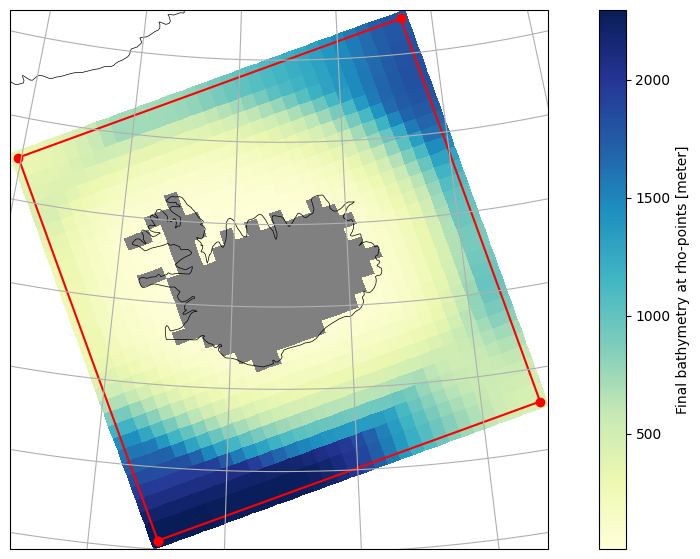

In [7]:
grid.plot(bathymetry=True)

We can also make a plot of the vertical coordinate system.

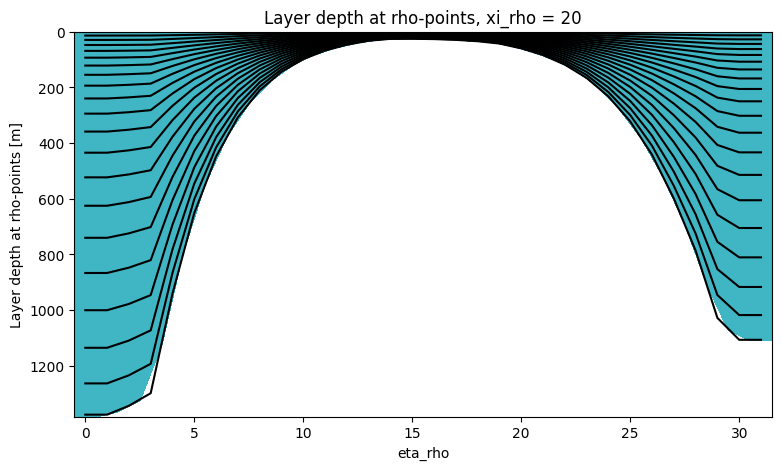

In [8]:
grid.plot_vertical_coordinate("layer_depth_rho", xi=20)

The big bump in the middle is Iceland!

To see the values of the grid variables, we can examine the `xarray.Dataset` object returned by the `.ds` property

In [9]:
grid.ds

<xarray.Dataset> Size: 620kB
Dimensions:              (eta_rho: 32, xi_rho: 32, xi_u: 31, eta_v: 31,
                          eta_psi: 33, xi_psi: 33, eta_coarse: 17,
                          xi_coarse: 17, s_rho: 20, s_w: 21)
Coordinates: (12/16)
    lat_rho              (eta_rho, xi_rho) float64 8kB 60.16 60.26 ... 69.65
    lon_rho              (eta_rho, xi_rho) float64 8kB 337.5 338.0 ... 348.4
    lat_u                (eta_rho, xi_u) float64 8kB 60.21 60.3 ... 69.56 69.62
    lon_u                (eta_rho, xi_u) float64 8kB 337.8 338.2 ... 347.4 348.0
    lat_v                (eta_v, xi_rho) float64 8kB 60.27 60.36 ... 69.48 69.54
    lon_v                (eta_v, xi_rho) float64 8kB 337.5 337.9 ... 347.8 348.5
    ...                   ...
    layer_depth_rho      (s_rho, eta_rho, xi_rho) float32 82kB 2.202e+03 ... ...
    layer_depth_u        (s_rho, eta_rho, xi_u) float32 79kB 2.202e+03 ... 6.793
    layer_depth_v        (s_rho, eta_v, xi_rho) float32 79kB 2.202e+03 ... 6.793
    interface_depth_rho  (s_w, eta_rho, xi_rho) float32 86kB 2.294e+03 ... -0.0
    interface_depth_u    (s_w, eta_rho, xi_u) float32 83kB 2.294e+03 ... -0.0
    interface_depth_v    (s_w, eta_v, xi_rho) float32 83kB 2.294e+03 ... -0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, eta_psi, xi_psi,
                                eta_coarse, xi_coarse, s_rho, s_w
Data variables: (12/13)
    angle                (eta_rho, xi_rho) float64 8kB 0.4133 0.4133 ... 0.259
    f                    (eta_rho, xi_rho) float64 8kB 0.0001262 ... 0.0001364
    pm                   (eta_rho, xi_rho) float64 8kB 3.754e-05 ... 3.754e-05
    pn                   (eta_rho, xi_rho) float64 8kB 3.758e-05 ... 3.758e-05
    spherical            |S1 1B b'T'
    mask_rho             (eta_rho, xi_rho) int32 4kB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    ...                   ...
    mask_v               (eta_v, xi_rho) int32 4kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    h                    (eta_rho, xi_rho) float64 8kB 2.294e+03 ... 1.778e+03
    angle_coarse         (eta_coarse, xi_coarse) float64 2kB 0.4118 ... 0.2604
    mask_coarse          (eta_coarse, xi_coarse) int32 1kB 1 1 1 1 1 ... 1 1 1 1
    Cs_r                 (s_rho) float32 80B -0.9579 -0.8615 ... -0.0002471
    Cs_w                 (s_w) float32 84B -1.0 -0.9114 ... -0.0009921 0.0
Attributes:
    title:               ROMS grid created by ROMS-Tools
    roms_tools_version:  0.1.dev138+dirty
    size_x:              800
    size_y:              800
    center_lon:          -18
    center_lat:          65
    rot:                 20
    topography_source:   ETOPO5
    hmin:                5.0
    theta_s:             5.0
    theta_b:             2.0
    hc:                  300.0

Once we are happy with our grid, we can save it as a netCDF file via the `.save` method:

In [10]:
grid.save(f"{target_dir}/grid.nc")

[PosixPath('/pscratch/sd/n/nloose/ROMS_TOOLS_INPUT_DATA/grid.nc')]

We can also export the grid parameters to a YAML file. This gives us a more storage-effective way to save and share input data made with `ROMS-Tools`. The YAML file can be used to recreate the same object later, and is compatible with both `ROMS-Tools` and `C-Star`.

In [11]:
yaml_filepath = f"{target_dir}/grid.yaml"
grid.to_yaml(yaml_filepath)

These are the contents of the written YAML file.

In [12]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev138+dirty
---
Grid:
  N: 20
  center_lat: 65
  center_lon: -18
  hc: 300.0
  hmin: 5.0
  nx: 30
  ny: 30
  rot: 20
  size_x: 800
  size_y: 800
  theta_b: 2.0
  theta_s: 5.0
  topography_source: ETOPO5



You can find more information about creating, plotting, and saving grids with `ROMS-Tools` [here](https://roms-tools.readthedocs.io/en/latest/grid.html).

## Initial Conditions

In [13]:
from roms_tools import InitialConditions

Here, we want to prepare a simulation in which we run ROMS with MARBL biogeochemistry (BGC), so we need to prepare both physical and BGC initial conditions. We create physical and BGC initial conditions **together** because ROMS needs a **single** initial conditions file. We use

* **GLORYS data** to create our physical initial conditions, i.e., temperature, salinity, sea surface height, and velocities
* a **biogeochemical (BGC) CESM climatology** to create our BGC initial conditions

In [14]:
glorys_path = "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120810.nc"
cesm_interior_path = "/global/cfs/projectdirs/m4746/Datasets/CESM_REGRIDDED/CESM-climatology_lowres_regridded.nc"

You can also download the GLORYS data yourself from https://www.mercator-ocean.eu/en/ocean-science/glorys/.

In [15]:
%%time
initial_conditions = InitialConditions(
    grid=grid,
    ini_time=start_time,
    source={"name": "GLORYS", "path": glorys_path},
    bgc_source={
        "name": "CESM_REGRIDDED",
        "path": cesm_interior_path,
        "climatology": True,
    },  # bgc_source is optional
    use_dask=False
)

Selected time entry closest to the specified start_time (2012-08-10 00:00:00) within the range [2012-08-10 00:00:00, 2012-08-11 00:00:00]: ['2012-08-10T12:00:00.000000000']
CPU times: user 36min 12s, sys: 9.89 s, total: 36min 22s
Wall time: 44.6 s


Including BGC initial conditions is optional. If you would like to only create physical intial conditions, you can skip the `bgc_source` argument, see also the [ROMS-Tools documentation](https://roms-tools.readthedocs.io/en/latest/initial_conditions.html).

To see the values of the intial conditions variables we can examine the `xarray.Dataset` object returned by the `.ds` property.

In [16]:
initial_conditions.ds

<xarray.Dataset> Size: 3MB
Dimensions:      (ocean_time: 1, eta_rho: 32, xi_rho: 32, s_rho: 20, xi_u: 31,
                  eta_v: 31, s_w: 21)
Coordinates:
    abs_time     (ocean_time) datetime64[ns] 8B 2012-08-10T12:00:00
  * ocean_time   (ocean_time) float64 8B 3.979e+08
Dimensions without coordinates: eta_rho, xi_rho, s_rho, xi_u, eta_v, s_w
Data variables: (12/42)
    zeta         (ocean_time, eta_rho, xi_rho) float32 4kB -0.6053 ... -0.8647
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 82kB 3.113 ... ...
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 82kB 34.96 ... ...
    u            (ocean_time, s_rho, eta_rho, xi_u) float32 79kB 0.02931 ... ...
    v            (ocean_time, s_rho, eta_v, xi_rho) float32 79kB 0.01259 ... ...
    ubar         (ocean_time, eta_rho, xi_u) float32 4kB 0.02655 ... -0.001648
    ...           ...
    diazFe       (ocean_time, s_rho, eta_rho, xi_rho) float32 82kB -4.748e-09...
    spCaCO3      (ocean_time, s_rho, eta_rho, xi_rho) float32 82kB 0.0001279 ...
    zooC         (ocean_time, s_rho, eta_rho, xi_rho) float32 82kB 0.3032 ......
    w            (ocean_time, s_w, eta_rho, xi_rho) float32 86kB 0.0 0.0 ... 0.0
    Cs_r         (s_rho) float32 80B -0.9579 -0.8615 ... -0.002245 -0.0002471
    Cs_w         (s_w) float32 84B -1.0 -0.9114 -0.809 ... -0.0009921 0.0
Attributes:
    title:                 ROMS initial conditions file created by ROMS-Tools
    roms_tools_version:    0.1.dev138+dirty
    ini_time:              2012-08-10 00:00:00
    model_reference_date:  2000-01-01 00:00:00
    source:                GLORYS
    bgc_source:            CESM_REGRIDDED
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0

Here is a plot of the uppermost layer of the temperature field.

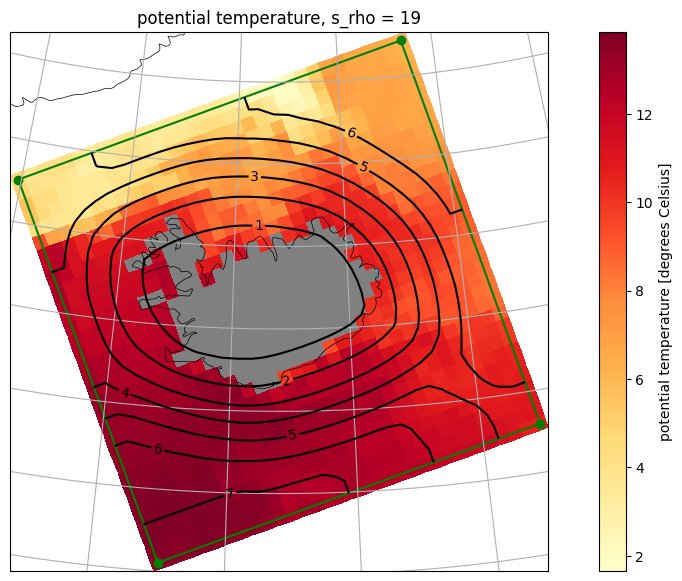

In [17]:
initial_conditions.plot("temp", s=-1, depth_contours=True)

We can also plot vertical sections of our initial conditions, for example alkalinity.

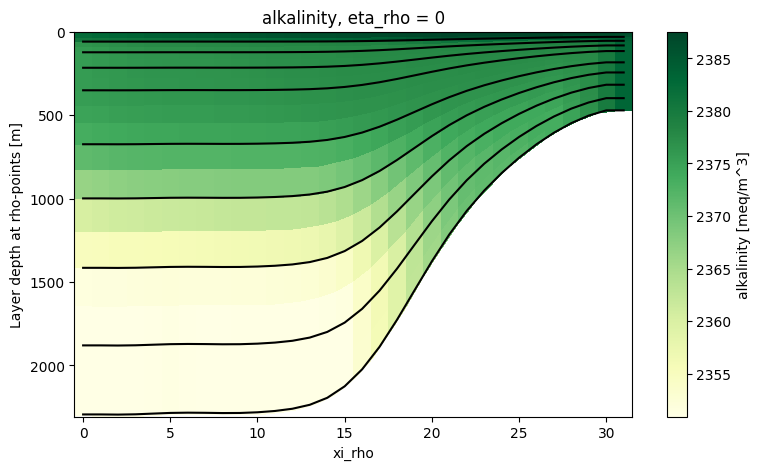

In [18]:
initial_conditions.plot("ALK", eta=0, layer_contours=True)

We can now save the dataset as a NetCDF and YAML file.

In [19]:
initial_conditions.save(f"{target_dir}/initial_conditions.nc")

[PosixPath('/pscratch/sd/n/nloose/ROMS_TOOLS_INPUT_DATA/initial_conditions.nc')]

In [20]:
initial_conditions.to_yaml(f"{target_dir}/initial_conditions.yaml")

You can find more information about creating, plotting, and saving initial conditions with `ROMS-Tools` [here](https://roms-tools.readthedocs.io/en/latest/initial_conditions.html).

## Tidal Forcing

Next, we create tidal forcing for our domain.

In [21]:
from roms_tools import TidalForcing

The tidal forcing is based on the TPXO atlas, which sits on perlmutter at the following location.

In [22]:
tpxo_path = "/global/cfs/projectdirs/m4746/Datasets/TPXO/tpxo9.v2a.nc"

You can also download your own version from https://www.tpxo.net/global. Note that `ROMS-Tools` currently only supports the TPXO9v2 version.

In [23]:
%%time

tidal_forcing = TidalForcing(
    grid=grid,
    source={"name": "TPXO", "path": tpxo_path},
    ntides=10,  # number of constituents to consider <= 14. Default is 10.
    use_dask=False
)

CPU times: user 39.1 s, sys: 4.09 s, total: 43.2 s
Wall time: 12.2 s


To see the values of the tidal forcing variables we can examine the `xarray.Dataset` object returned by the `.ds` property.

In [24]:
tidal_forcing.ds

<xarray.Dataset> Size: 323kB
Dimensions:  (ntides: 10, eta_rho: 32, xi_rho: 32, xi_u: 31, eta_v: 31)
Coordinates:
    omega    (ntides) float64 80B 0.0001405 0.0001454 ... 2.639e-06 5.323e-06
Dimensions without coordinates: ntides, eta_rho, xi_rho, xi_u, eta_v
Data variables:
    ssh_Re   (ntides, eta_rho, xi_rho) float32 41kB 0.6173 0.6247 ... -0.0198
    ssh_Im   (ntides, eta_rho, xi_rho) float32 41kB -0.4568 ... -0.007206
    pot_Re   (ntides, eta_rho, xi_rho) float32 41kB 0.05192 ... -0.0007893
    pot_Im   (ntides, eta_rho, xi_rho) float32 41kB 0.008197 ... 0.002649
    u_Re     (ntides, eta_rho, xi_u) float32 40kB -0.01072 ... 8.424e-05
    u_Im     (ntides, eta_rho, xi_u) float32 40kB 0.006649 ... -1.048e-05
    v_Re     (ntides, eta_v, xi_rho) float32 40kB 0.02044 0.02003 ... 0.00015
    v_Im     (ntides, eta_v, xi_rho) float32 40kB -0.007885 ... -0.0001538
Attributes:
    title:                 ROMS tidal forcing created by ROMS-Tools
    roms_tools_version:    0.1.dev138+dirty
    source:                TPXO
    model_reference_date:  2000-01-01 00:00:00
    allan_factor:          2.0

We can also plot any of the tidal forcing fields via the `.plot` method.

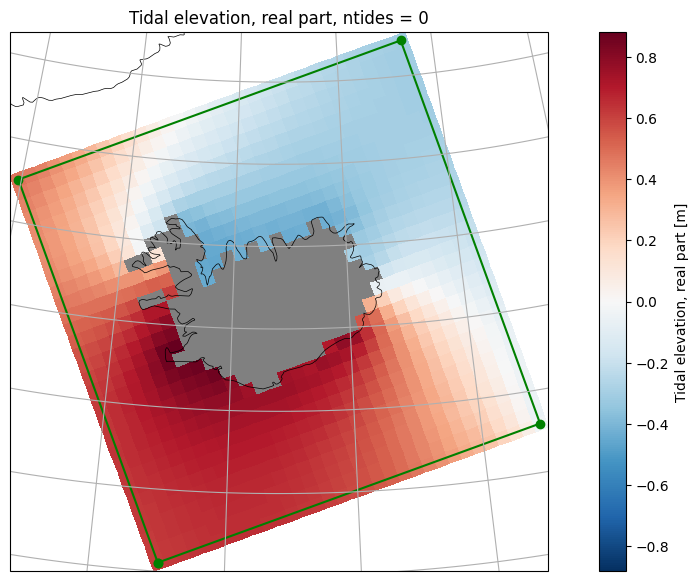

In [25]:
tidal_forcing.plot("ssh_Re", ntides=0)

Finally, we can save our tidal forcing as a netCDF file via the `.save` method.

In [26]:
tidal_forcing.save(f"{target_dir}/tidal_forcing.nc")

[PosixPath('/pscratch/sd/n/nloose/ROMS_TOOLS_INPUT_DATA/tidal_forcing.nc')]

Again, we can also export the parameters of our `TidalForcing` object to a YAML file.

In [27]:
tidal_forcing.to_yaml(f"{target_dir}/tidal_forcing.yaml")

You can find more information about creating, plotting, and saving tidal forcing with `ROMS-Tools` [here](https://roms-tools.readthedocs.io/en/latest/tides.html).

## Surface Forcing
Next, we create the surface forcing for our domain.

In [28]:
from roms_tools import SurfaceForcing

`ROMS-Tools` can create two types of surface forcing:

* **physical surface forcing** like 10m wind, shortwave radiation, and air temperature at 2m
* **biogeochemical (BGC) surface forcing** like atmospheric pCO2

Unlike initial conditions data, ROMS can read multiple surface forcing files, so we create these two types separately.

### Physical Surface Forcing

In this subsection, we use ERA5 data to create our physical surface forcing. Our downloaded ERA5 data sits at the following location on perlmutter.

In [29]:
era5_path = "/global/cfs/projectdirs/m4746/Datasets/ERA5/NA/2012/ERA5_2012-08.nc"

Note that the ERA5 data can also be found online at the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/).

We now create an instance of the `SurfaceForcing` class with `type = "physics"`.

In [30]:
%%time
surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": era5_path},
    correct_radiation=True, 
    type="physics",
    use_dask=False
)

CPU times: user 2.84 s, sys: 1.76 s, total: 4.61 s
Wall time: 11.1 s


The surface forcing variables are held in an `xarray.Dataset` that is accessible via the `.ds` property.

In [31]:
surface_forcing.ds

<xarray.Dataset> Size: 5MB
Dimensions:   (time: 169, eta_rho: 32, xi_rho: 32)
Coordinates:
    abs_time  (time) datetime64[ns] 1kB 2012-08-10 ... 2012-08-17
  * time      (time) float64 1kB 4.605e+03 4.605e+03 ... 4.612e+03 4.612e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 692kB 4.614 4.477 ... -6.576
    vwnd      (time, eta_rho, xi_rho) float32 692kB 6.843 6.547 ... 2.708 2.479
    swrad     (time, eta_rho, xi_rho) float32 692kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwrad     (time, eta_rho, xi_rho) float32 692kB 373.6 372.3 ... 351.5 351.1
    Tair      (time, eta_rho, xi_rho) float32 692kB 13.4 13.39 ... 7.637 7.589
    qair      (time, eta_rho, xi_rho) float32 692kB 0.009185 ... 0.006327
    rain      (time, eta_rho, xi_rho) float32 692kB 0.07931 0.0719 ... 0.6849
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev138+dirty
    start_time:            2012-08-10 00:00:00
    end_time:              2012-08-17 00:00:00
    source:                ERA5
    correct_radiation:     True
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

Since the ERA5 data comes at hourly frequency, `ROMS-Tools` has processed 169 time slices - a week worth of hourly surface forcing.

To visualize any of the surface forcing fields, we can use the `.plot` method.

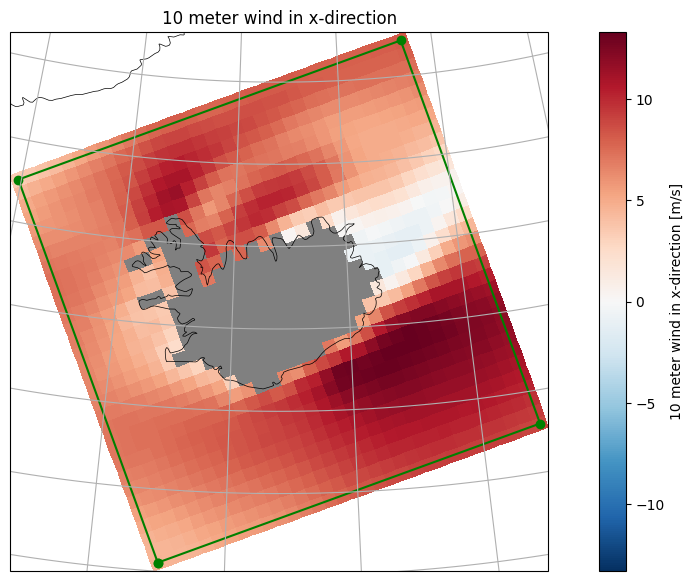

In [32]:
surface_forcing.plot("uwnd", time=0)

Let's save our physical surface forcing to NetCDF and YAML files.

In [33]:
surface_forcing.save(f"{target_dir}/physical_surface_forcing.nc")

[PosixPath('/pscratch/sd/n/nloose/ROMS_TOOLS_INPUT_DATA/physical_surface_forcing_201208.nc')]

From the path printed to screen, you can see that `ROMS-Tools` appended `_201208` to the file path that we specified. If we had asked for a time range spanning several months, `ROMS-Tools` would have written several files (ordered by months).

In [34]:
surface_forcing.to_yaml(f"{target_dir}/physical_surface_forcing.yaml")

### Biogeochemical (BGC) Surface Forcing
We now create BGC surface forcing. The BGC variables are interpolated from a CESM dataset with monthly frequency, which is located here.

In [35]:
cesm_surface_path = "/global/cfs/projectdirs/m4746/Datasets/CESM_REGRIDDED/CESM-surface_lowres_regridded.nc"

In [36]:
%%time

bgc_surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "CESM_REGRIDDED", "path": cesm_surface_path},
    type="bgc",
    use_dask=False
)

CPU times: user 107 ms, sys: 4.05 ms, total: 111 ms
Wall time: 949 ms


In [37]:
bgc_surface_forcing.ds

<xarray.Dataset> Size: 49kB
Dimensions:       (time: 2, eta_rho: 32, xi_rho: 32)
Coordinates:
    abs_time      (time) datetime64[ns] 16B 2012-08-01 2012-09-01
    pco2_time     (time) float64 16B 4.596e+03 4.627e+03
    iron_time     (time) float64 16B 4.596e+03 4.627e+03
    dust_time     (time) float64 16B 4.596e+03 4.627e+03
    nox_time      (time) float64 16B 4.596e+03 4.627e+03
    nhy_time      (time) float64 16B 4.596e+03 4.627e+03
Dimensions without coordinates: time, eta_rho, xi_rho
Data variables:
    pco2_air      (time, eta_rho, xi_rho) float32 8kB 314.8 313.8 ... 297.4
    pco2_air_alt  (time, eta_rho, xi_rho) float32 8kB 314.8 313.8 ... 297.4
    iron          (time, eta_rho, xi_rho) float32 8kB 5.547e-08 ... 9.885e-08
    dust          (time, eta_rho, xi_rho) float32 8kB 3.269e-12 ... 1.319e-11
    nox           (time, eta_rho, xi_rho) float32 8kB 2.078e-12 ... 1.45e-12
    nhy           (time, eta_rho, xi_rho) float32 8kB 1.186e-12 ... 4.717e-13
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev138+dirty
    start_time:            2012-08-10 00:00:00
    end_time:              2012-08-17 00:00:00
    source:                CESM_REGRIDDED
    correct_radiation:     False
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  bgc

The CESM data has monthly frequency, so `ROMS-Tools` has only processed two time slices.

We can plot the BGC surface forcing as we saw above.

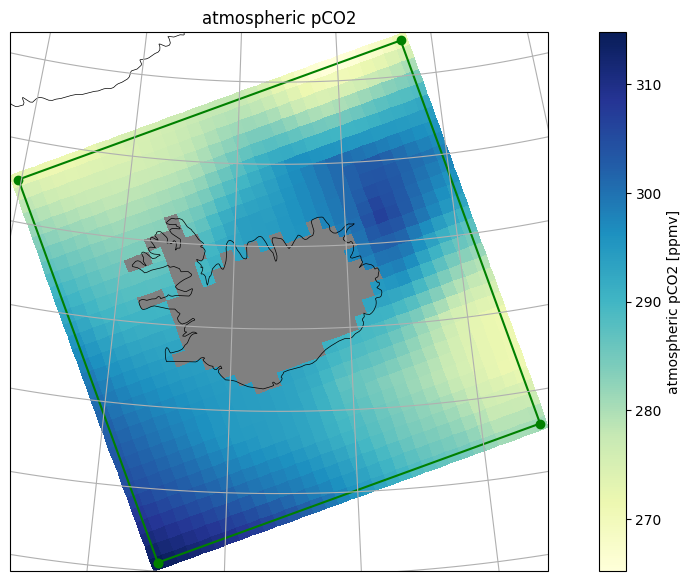

In [38]:
bgc_surface_forcing.plot("pco2_air", time=0)

Finally, we save our BGC surface forcing to NetCDF and YAML files.

In [39]:
bgc_surface_forcing.save(f"{target_dir}/bgc_surface_forcing.nc")

[PosixPath('/pscratch/sd/n/nloose/ROMS_TOOLS_INPUT_DATA/bgc_surface_forcing_2012.nc')]

From the path printed to screen, you can see that `ROMS-Tools` appended `_2012` to the file path that we specified. Since the provided BGC has monthly frequency (as opposed to the hourly ERA5 data), `ROMS-Tools` ordered the processed data by years (as opposed to months).

In [40]:
bgc_surface_forcing.to_yaml(f"{target_dir}/bgc_surface_forcing.yaml")

You can find more information about creating, plotting, and saving surface forcing with `ROMS-Tools` [here](https://roms-tools.readthedocs.io/en/latest/surface_forcing.html).

## Boundary Forcing
The last input data necessary for ROMS is the boundary forcing (or, equivalently, the open boundary conditions).

In [41]:
from roms_tools import BoundaryForcing

`ROMS-Tools` can create two types of boundary forcing:

* **physical boundary forcing** like temperature, salinity, velocities, and sea surface height
* **biogeochemical (BGC) boundary forcing** like alkalinity, dissolved inorganic phosphate, etc.

As with surface forcing, ROMS accepts multiple boundary forcing files, so we create these two types separately.

### Physical boundary forcing

We use the same GLORYS data as above to create our physical boundary forcing.

We now create an instance of the `BoundaryForcing` class with `type = "physics"`.

Now we need a week worth of GLORYS data, so we have to update our `glorys_path`.

In [42]:
glorys_path = [
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120809.nc", # include data from day before start time, just to be save
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120810.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120811.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120812.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120813.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120814.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120815.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120816.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120817.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120818.nc" # include data from day after end time, just to be save
]

Note that we could have also specified the data location via a wildcard, e.g., `path='/glade/derecho/scratch/bachman/GLORYS/NA/2012/*.nc'`. But with this latter choice, `ROMS-Tools` can operate quite a bit slower (especially if you experiment with `use_dask = True`). More specific filenames are better!

In [43]:
%%time

boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "GLORYS", "path": glorys_path},
    type="physics",  # "physics" or "bgc"; default is "physics"
    use_dask=False
)

CPU times: user 5h 10min 47s, sys: 17.9 s, total: 5h 11min 5s
Wall time: 2min 57s


The boundary forcing variables are held in an `xarray.Dataset` that is accessible via the `.ds` property.

In [44]:
boundary_forcing.ds

<xarray.Dataset> Size: 380kB
Dimensions:     (bry_time: 9, xi_rho: 32, s_rho: 20, xi_u: 31, eta_rho: 32,
                 eta_v: 31)
Coordinates:
    abs_time    (bry_time) datetime64[ns] 72B 2012-08-09T12:00:00 ... 2012-08...
  * bry_time    (bry_time) float64 72B 4.604e+03 4.606e+03 ... 4.612e+03
Dimensions without coordinates: xi_rho, s_rho, xi_u, eta_rho, eta_v
Data variables: (12/28)
    zeta_south  (bry_time, xi_rho) float32 1kB -0.5871 -0.5853 ... -0.4932
    temp_south  (bry_time, s_rho, xi_rho) float32 23kB 3.113 3.134 ... 11.34
    salt_south  (bry_time, s_rho, xi_rho) float32 23kB 34.95 34.95 ... 35.26
    u_south     (bry_time, s_rho, xi_u) float32 22kB 0.03371 0.02327 ... 0.05322
    v_south     (bry_time, s_rho, xi_rho) float32 23kB 0.007455 ... 0.01006
    ubar_south  (bry_time, xi_u) float32 1kB 0.03021 -0.02001 ... 0.1054 0.06859
    ...          ...
    temp_west   (bry_time, s_rho, eta_rho) float32 23kB 3.113 3.17 ... 2.878
    salt_west   (bry_time, s_rho, eta_rho) float32 23kB 34.95 34.96 ... 31.85
    u_west      (bry_time, s_rho, eta_rho) float32 23kB 0.03371 ... -0.03375
    v_west      (bry_time, s_rho, eta_v) float32 22kB 0.007455 ... 0.04785
    ubar_west   (bry_time, eta_rho) float32 1kB 0.03021 -0.03052 ... 0.01929
    vbar_west   (bry_time, eta_v) float32 1kB 0.03951 0.04327 ... -0.01109
Attributes:
    title:                 ROMS boundary forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev138+dirty
    start_time:            2012-08-10 00:00:00
    end_time:              2012-08-17 00:00:00
    source:                GLORYS
    model_reference_date:  2000-01-01 00:00:00
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0

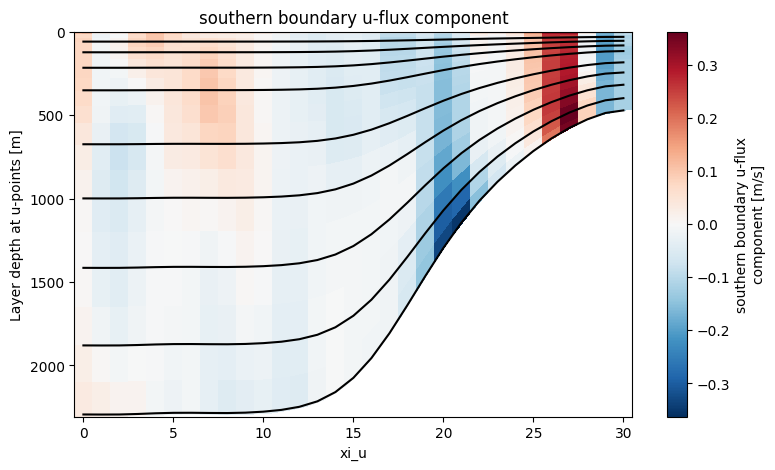

In [45]:
boundary_forcing.plot("u_south", time=0, layer_contours=True)

In [46]:
boundary_forcing.save(f"{target_dir}/physical_boundary_forcing.nc")

[PosixPath('/pscratch/sd/n/nloose/ROMS_TOOLS_INPUT_DATA/physical_boundary_forcing_201208.nc')]

In [47]:
boundary_forcing.to_yaml(f"{target_dir}/physical_boundary_forcing.yaml")

### Biogeochemical (BGC) boundary forcing
We now create BGC boundary forcing. The BGC variables are interpolated from the same CESM climatology as above.

In [ ]:
%%time

bgc_boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "CESM_REGRIDDED", "path": cesm_interior_path, "climatology": True},
    type="bgc",
    use_dask=False,
)

In [ ]:
bgc_boundary_forcing.ds

In [ ]:
bgc_boundary_forcing.plot("ALK_east", time=0, layer_contours=True)

In [ ]:
bgc_boundary_forcing.save(f"{target_dir}/bgc_boundary_forcing.nc")

In [ ]:
bgc_boundary_forcing.to_yaml(f"{target_dir}/bgc_boundary_forcing.yaml")

You can find more information about creating, plotting, and saving boundary forcing with `ROMS-Tools` [here](https://roms-tools.readthedocs.io/en/latest/boundary_forcing.html).

## Summary

We created the following NetCDF files (filenames were returned by the `save()` method):

* Grid: `{target_dir}/grid.nc`
* Initial Conditions: `{target_dir}/initial_conditions.nc`
* Tidal Forcing: `{target_dir}/tidal_forcing.nc`
* Physical Surface Forcing: `{target_dir}/physical_surface_forcing_201208.nc`
* BGC Surface Forcing: `{target_dir}/bgc_surface_forcing_2012.nc`
* Physical Boundary Forcing: `{target_dir}/physical_boundary_forcing_201208.nc`
* BGC Boundary Forcing: `{target_dir}/bgc_boundary_forcing_clim.nc`

We also created the following YAML files that can be used to re-create the exact same `ROMS-Tools` objects and NetCDF files:

* Grid: `{target_dir}/grid.yaml`
* Initial Conditions: `{target_dir}/initial_conditions.yaml`
* Tidal Forcing: `{target_dir}/tidal_forcing.yaml`
* Physical Surface Forcing: `{target_dir}/physical_surface_forcing.yaml`
* BGC Surface Forcing: `{target_dir}/bgc_surface_forcing.yaml`
* Physical Boundary Forcing: `{target_dir}/physical_boundary_forcing.yaml`
* BGC Boundary Forcing: `{target_dir}/bgc_boundary_forcing.yaml`

The paths to these input files (either the NetCDF files or the YAML files) can now be used to set up a ROMS simulation with `C-Star`.